# Demonstration of anomaly detection with CVAE using DASHlink data

**Author: Milad Memarzadeh (milad.memarzadeh@nasa.gov)**


# Import Libraries

In [34]:
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, precision_recall_curve, average_precision_score
from sklearn.utils import shuffle
from source.modelsCondVAE import *
from source.utilsCondVAEs5 import *
from itertools import combinations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [35]:
k_folds = 2
train_learning_rate = 1e-4 #1e-3
finetune_learning_rate = 1e-5 #1e-4
train_num_epochs = 50 #10
finetune_num_epochs = 5

latent_dim = 10
batch_size = 64
window_size = 10


# Load and preprocess data

In [36]:
def load_tsm_binary(tsm_path, window_size=1024, step_size=1024):
    """
    Reads the TSM file as binary data and creates fixed-size windows.
    Automatically labels the file as "0" if the file name includes "normal"
    (case insensitive); otherwise, labels it as "1".
    
    Args:
        tsm_path (str): Path to the TSM file.
        window_size (int): Size of each window in bytes.
        step_size (int): Number of bytes to step for each new window.
                         Using window_size produces non-overlapping windows.
    
    Returns:
        X (np.ndarray): Array of shape (n_samples, window_size) containing binary data.
        y (np.ndarray): Array of labels for each window.
    """
    # Determine label based on file name
    file_name = os.path.basename(tsm_path).lower()
    label = 0 if "normal" in file_name else 1
    
    # Open and read the file in binary mode
    with open(tsm_path, 'rb') as f:
        binary_data = f.read()
    
    # Convert the binary data into a NumPy array of uint8 values (0-255)
    data_array = np.frombuffer(binary_data, dtype=np.uint8)
    
    # Create sliding windows from the binary data
    X = []
    for start in range(0, len(data_array) - window_size + 1, step_size):
        window = data_array[start:start + window_size]
        X.append(window)
    
    X = np.array(X)
    # Create an array of labels based on the determined label for this file
    y = np.full(len(X), label, dtype=int)
    
    return X, y

In [37]:
tsm_folder_path = "C:/Users/jed95/Documents/GitHub/CVAE/data/tsm/" 

# Adjust window_size and step_size as needed
window_size = 512
step_size = 512


X_train_normal, y_train_normal = load_tsm_binary(tsm_folder_path+"X_train_normal.tsm", window_size=window_size, step_size=step_size)
X_train_anomalous, y_train_anomalous = load_tsm_binary(tsm_folder_path+"X_train_anomalous.tsm", window_size=window_size, step_size=step_size)
X_test_normal, y_test_normal = load_tsm_binary(tsm_folder_path+"X_test_normal.tsm", window_size=window_size, step_size=step_size)
X_test_anomalous, y_test_anomalous = load_tsm_binary(tsm_folder_path+"X_test_anomalous.tsm", window_size=window_size, step_size=step_size)
X_val_normal, y_val_normal = load_tsm_binary(tsm_folder_path+"X_val_normal.tsm", window_size=window_size, step_size=step_size)
X_val_anomalous, y_val_anomalous = load_tsm_binary(tsm_folder_path+"X_val_anomalous.tsm", window_size=window_size, step_size=step_size)




In [38]:
# Combine training data
X_train = np.concatenate([X_train_normal, X_train_anomalous], axis=0)
y_train = np.concatenate([y_train_normal, y_train_anomalous], axis=0)
# Combine validation data
X_val = np.concatenate([X_val_normal, X_val_anomalous], axis=0)
y_val = np.concatenate([y_val_normal, y_val_anomalous], axis=0)
# Combine test data
X_test = np.concatenate([X_test_normal, X_test_anomalous], axis=0)
y_test = np.concatenate([y_test_normal, y_test_anomalous], axis=0)
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)


Training data shape: (54222, 512) (54222,)
Validation data shape: (53111, 512) (53111,)
Test data shape: (161449, 512) (161449,)


In [39]:
# Shuffle data

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# Convert Data to Tensors

In [40]:
# Convert training data to tensors
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).long()
# Convert validation data to tensors
X_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val).long()
# Convert test data to tensors
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).long()


# Create Data Loaders for Labeled and Unlabeled Data

In [41]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # Now labels are provided for all data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = self.data[idx]
        y = self.labels[idx]
        return X, y


In [42]:
# Training data loader
train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) #TODO adjust Shuffle training data? 
full_train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
# Validation data loader
val_dataset = TimeSeriesDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Test data loader
test_dataset = TimeSeriesDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Instantiate and Train the Conditional VAE

In [43]:
def evaluate_model(model, data_loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)

            # Forward pass
            x_rec, class_logits = model(data)
            
            # Compute classification loss
            loss = criterion(class_logits, target)
            total_loss += loss.item() * data.size(0)

            # Compute accuracy
            preds = class_logits.argmax(dim=1)
            total_correct += (preds == target).sum().item()
            total_samples += data.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples

    return avg_loss, avg_acc


In [44]:

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
model_name="CondVAE_model"
save_dir="./"
# Instantiate the model
num_param = 1    # Since we have univariate time series

num_classes = 2  # Normal and Anomaly
scale_flag = 0   # Use Sigmoid activation in the decoder

results = {}

# Start k-fold cross-validation
print('Starting k-fold cross-validation...')
time_start = time.time()
for fold, (train_idx, val2_idx) in enumerate(skf.split(np.zeros(len(y_train_tensor)), y_train_tensor.cpu().numpy())):
    print(f'Fold {fold+1}/{k_folds}')
    
    # Create data loaders for the current fold
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val2_subsampler = torch.utils.data.SubsetRandomSampler(val2_idx)
    
    train_loader = DataLoader(full_train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val2_loader = DataLoader(full_train_dataset, batch_size=batch_size, sampler=val2_subsampler)
    
    # Initialize the model for this fold
    model = VAE(latent_dim, num_param, window_size, num_classes, scale_flag).to(device)
    
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=train_learning_rate)
    
    # Train the model 
    model = train_model(
    model,
    optimizer,
    train_loader,
    num_epochs=train_num_epochs,
    save=False, # TODO: True
    save_dir=save_dir,
    model_name=model_name)
    
    # Evaluate the model on validation data
    val_loss, val_acc = evaluate_model(model, val2_loader)
    
    # Save the results for this fold
    results[fold] = {'val_loss': val_loss, 'val_acc': val_acc}
    
    print(f'Fold {fold+1} Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

time_end = time.time()

buffer = io.BytesIO()
torch.save(model.state_dict(), buffer)



Starting k-fold cross-validation...
Fold 1/2
Epoch [1/50], Total Loss: nan, Rec Loss: nan, KL Div: nan, Class Loss: nan
Epoch [2/50], Total Loss: nan, Rec Loss: nan, KL Div: nan, Class Loss: nan
Epoch [3/50], Total Loss: nan, Rec Loss: nan, KL Div: nan, Class Loss: nan
Epoch [4/50], Total Loss: nan, Rec Loss: nan, KL Div: nan, Class Loss: nan
Epoch [5/50], Total Loss: nan, Rec Loss: nan, KL Div: nan, Class Loss: nan
Epoch [6/50], Total Loss: nan, Rec Loss: nan, KL Div: nan, Class Loss: nan
Epoch [7/50], Total Loss: nan, Rec Loss: nan, KL Div: nan, Class Loss: nan
Epoch [8/50], Total Loss: nan, Rec Loss: nan, KL Div: nan, Class Loss: nan
Epoch [9/50], Total Loss: nan, Rec Loss: nan, KL Div: nan, Class Loss: nan
Epoch [10/50], Total Loss: nan, Rec Loss: nan, KL Div: nan, Class Loss: nan
Epoch [11/50], Total Loss: nan, Rec Loss: nan, KL Div: nan, Class Loss: nan
Epoch [12/50], Total Loss: nan, Rec Loss: nan, KL Div: nan, Class Loss: nan
Epoch [13/50], Total Loss: nan, Rec Loss: nan, KL Di

In [45]:
def plot_training_loss(model_name, save_dir):
    training_traj = np.load(save_dir+model_name+"_training_loss.npz")

    total_loss = training_traj['training_total_loss']
    rec_loss = training_traj['training_rec_loss']
    kl_loss = training_traj['training_kl_loss']
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.title("Total Loss", fontsize=12)
    plt.plot(range(len(total_loss)), total_loss)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.subplot(1, 3, 2)
    plt.title("Reconstruction Loss", fontsize=12)
    plt.plot(range(len(total_loss)), rec_loss)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel("Epochs of training", fontsize=12)
    plt.subplot(1, 3, 3)
    plt.title("KL Loss", fontsize=12)
    plt.plot(range(len(total_loss)), kl_loss)
    plt.tick_params(axis='both', which='major', labelsize=14)
#plot_training_loss(model_name, save_dir)

# Initialize 3 new models for fine-tuning

In [46]:
# Deserialize the model from the buffer
buffer.seek(0)  # Reset buffer pointer to the beginning
model_medium = VAE(latent_dim, num_param, window_size, num_classes, scale_flag).to(device)
model_medium.load_state_dict(torch.load(buffer))
model_medium = model_medium.to(device)

buffer.seek(0)  # Reset buffer pointer to the beginning
model_strong = VAE(latent_dim, num_param, window_size, num_classes, scale_flag).to(device)
model_strong.load_state_dict(torch.load(buffer))
model_strong = model_strong.to(device)
buffer.seek(0)  # Reset buffer pointer to the beginPrecision = 100.0%, recall = 0.41% and F1-score = 0.81%ing
model_random = VAE(latent_dim, num_param, window_size, num_classes, scale_flag).to(device)
model_random.load_state_dict(torch.load(buffer))
model_random = model_random.to(device)


# Verify the 3 new models

In [47]:
# Initialize a flag
models_identical = True
original_state_dict = model.state_dict()
loaded_state_dict = model_medium.state_dict()
# Compare each parameter
for key in original_state_dict:
    original_param = original_state_dict[key]
    loaded_param = loaded_state_dict[key]
    if not torch.equal(original_param, loaded_param):
        print(f"Mismatch found at layer: {key}")
        models_identical = False
        break

if models_identical:
    print("The saved and loaded models are identical.")
else:
    print("The models are not identical.")
# Initialize a flag
models_identical = True
original_state_dict = model_random.state_dict()
loaded_state_dict = model_medium.state_dict()
# Compare each parameter
for key in original_state_dict:
    original_param = original_state_dict[key]
    loaded_param = loaded_state_dict[key]
    if not torch.equal(original_param, loaded_param):
        print(f"Mismatch found at layer: {key}")
        models_identical = False
        break

if models_identical:
    print("The saved and loaded models are identical.")
else:
    print("The models are not identical.")
# Initialize a flag
models_identical = True
original_state_dict = model.state_dict()
loaded_state_dict = model_strong.state_dict()
# Compare each parameter
for key in original_state_dict:
    original_param = original_state_dict[key]
    loaded_param = loaded_state_dict[key]
    if not torch.equal(original_param, loaded_param):
        print(f"Mismatch found at layer: {key}")
        models_identical = False
        break

if models_identical:
    print("The saved and loaded models are identical.")
else:
    print("The models are not identical.")

Mismatch found at layer: encoder.fc_layers.0.weight
The models are not identical.
Mismatch found at layer: encoder.fc_layers.0.weight
The models are not identical.
Mismatch found at layer: encoder.fc_layers.0.weight
The models are not identical.


# Evaluate the Model and Detect Anomalies

In [48]:
def compute_anomaly_scores(model, data_loader):
    model.eval()
    rec_errors = []
    anomaly_probs = []
    true_labels = []
    predictions = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.unsqueeze(1).to(device)
            y_batch = y_batch.to(device)

            x_rec, class_logits = model(X_batch)
            y_probs = F.softmax(class_logits, dim=1)

            # Reconstruction error
            rec_error = torch.mean((X_batch - x_rec) ** 2, dim=[1, 2])

            # Classification probability for anomaly class
            anomaly_prob = y_probs[:, 1]

            # Combine scores
            #anomaly_score = rec_error * anomaly_prob
            rec_errors.extend(rec_error.cpu().numpy())
            anomaly_probs.extend(anomaly_prob.cpu().numpy())
            true_labels.extend(y_batch.cpu().numpy())
            predictions.extend(torch.argmax(class_logits, dim=1).cpu().numpy())

    return np.array(rec_errors), np.array(anomaly_probs), np.array(true_labels), np.array(predictions)

# Compute anomaly scores
train_rec_errors, train_anomaly_probs, train_true_labels, train_predictions = compute_anomaly_scores(model, train_loader)
val_rec_errors, val_anomaly_probs, val_true_labels, val_predictions = compute_anomaly_scores(model, val_loader)
test_rec_errors, test_anomaly_probs, test_true_labels, test_predictions = compute_anomaly_scores(model, test_loader)

#print(test_anomaly_scores)
info = precision_recall_fscore_support(test_true_labels, test_predictions, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))



Precision = 0.0%, recall = 0.0% and F1-score = 0.0%


c:\Users\jed95\.conda\envs\cvae\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


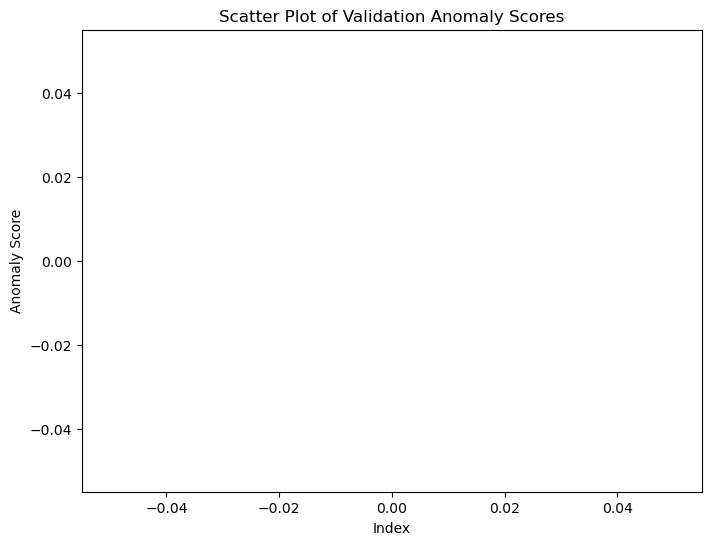

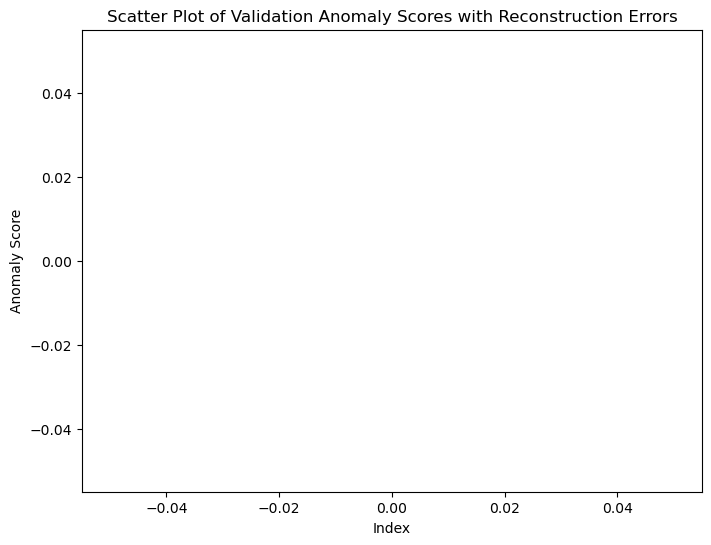

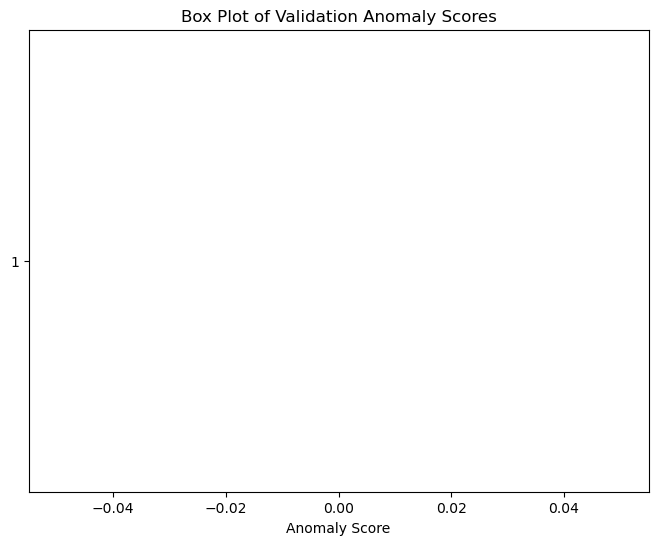

c:\Users\jed95\.conda\envs\cvae\lib\site-packages\matplotlib\axes\_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\Users\jed95\.conda\envs\cvae\lib\site-packages\matplotlib\axes\_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

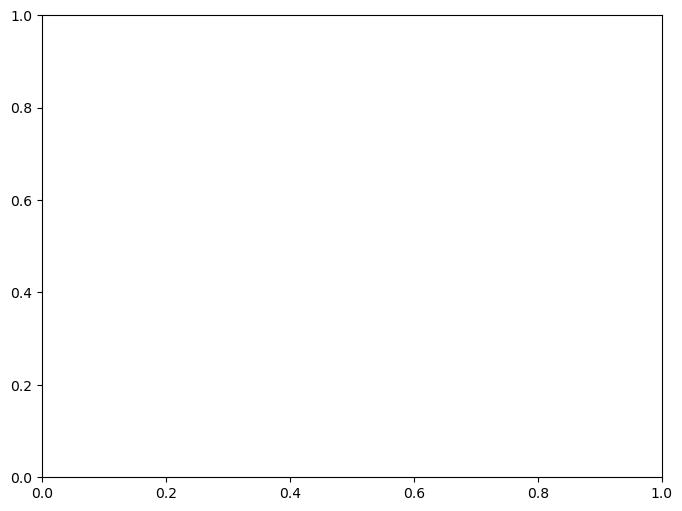

In [49]:

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(range(len(val_anomaly_probs)), val_anomaly_probs, alpha=0.7, c=(val_true_labels!=val_predictions), cmap='coolwarm')
plt.title("Scatter Plot of Validation Anomaly Scores")
plt.xlabel("Index")
plt.ylabel("Anomaly Score")
plt.show()

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(val_rec_errors, val_anomaly_probs, alpha=0.7, c=(val_true_labels==val_predictions), cmap='coolwarm')
plt.title("Scatter Plot of Validation Anomaly Scores with Reconstruction Errors")
plt.xlabel("Index")
plt.ylabel("Anomaly Score")
plt.show()

# Box Plot
plt.figure(figsize=(8, 6))
plt.boxplot(val_anomaly_probs, vert=False)
plt.title("Box Plot of Validation Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.show()

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(val_anomaly_probs, bins=20, alpha=0.7, edgecolor='black')
plt.title("Histogram of Validation Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()


In [ ]:

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(range(len(val_rec_errors)), val_rec_errors, alpha=0.7, c=val_true_labels, cmap='coolwarm')
plt.title("Scatter Plot of Validation Anomaly Scores (true labels)")
plt.xlabel("Index")
plt.ylabel("Anomaly Score")
plt.show()
# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(range(len(val_rec_errors)), val_rec_errors, alpha=0.7, c=val_predictions, cmap='coolwarm')
plt.title("Scatter Plot of Validation Anomaly Scores (predictions)")
plt.xlabel("Index")
plt.ylabel("Anomaly Score")
plt.show()
# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(range(len(val_rec_errors)), val_rec_errors, alpha=0.7, c=val_anomaly_probs, cmap='coolwarm')
plt.title("Scatter Plot of Validation Anomaly Scores (anomalous probability)")
plt.xlabel("Index")
plt.ylabel("Anomaly Score")
plt.show()

# Box Plot
plt.figure(figsize=(8, 6))
plt.boxplot(val_rec_errors, vert=False)
plt.title("Box Plot of Validation Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.show()

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(val_rec_errors, bins=20, alpha=0.7, edgecolor='black')
plt.title("Histogram of Validation Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()


# Retrain

In [ ]:
# Determine thresholds
#lower_percentile = 62.5
#upper_percentile = 37.5
#lower_threshold = np.percentile(val_anomaly_probs, lower_percentile)
#upper_threshold = np.percentile(val_anomaly_probs, upper_percentile)


# Select medium-score data
medium_score_indices = np.where((val_anomaly_probs >= 0.05) & (val_anomaly_probs <= 0.95))[0]
X_medium = X_val[medium_score_indices]
y_medium = y_val[medium_score_indices]
print("Medium-score data shape:", X_medium.shape, y_medium.shape)
X_medium_tensor = torch.tensor(X_medium).float()
y_medium_tensor = torch.tensor(y_medium).long()
# data loader
medium_dataset = TimeSeriesDataset(X_medium_tensor, y_medium_tensor)
medium_loader = DataLoader(medium_dataset, batch_size=batch_size, shuffle=False)



In [ ]:
# Determine thresholds
#lower_percentile = 12.5
#upper_percentile = 87.5
#lower_threshold = np.percentile(val_anomaly_probs, lower_percentile)
#upper_threshold = np.percentile(val_anomaly_probs, upper_percentile)

# Select strong-score data
strong_score_indices = np.where((val_anomaly_probs <= 0.01) | (val_anomaly_probs >= 0.99))[0]
X_strong = X_val[strong_score_indices]
y_strong = y_val[strong_score_indices]
print("Strong-score data shape:", X_strong.shape, y_strong.shape)
X_strong_tensor = torch.tensor(X_strong).float()
y_strong_tensor = torch.tensor(y_strong).long()
# data loader
strong_dataset = TimeSeriesDataset(X_strong_tensor, y_strong_tensor)
strong_loader = DataLoader(strong_dataset, batch_size=batch_size, shuffle=False)



In [ ]:
# Optional: Set a random seed for reproducibility
np.random.seed(42)

# Define the fraction of data to select
sample_fraction = 0.25
total_samples = len(val_anomaly_probs)
sample_size = int(sample_fraction * total_samples)

# Randomly select unique indices without replacement
random_score_indices = np.random.choice(total_samples, size=sample_size, replace=False)

# Select the corresponding data and labels
X_random = X_val[random_score_indices]
y_random = y_val[random_score_indices]
print("Random data shape:", X_random.shape, y_random.shape)
# Convert to PyTorch tensors
X_random_tensor = torch.tensor(X_random).float()
y_random_tensor = torch.tensor(y_random).long()

# Create the dataset and data loader
random_dataset = TimeSeriesDataset(X_random_tensor, y_random_tensor)
random_loader = DataLoader(random_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# FInetune the model
model_name = "model_medium"
optimizer = optim.Adam(model_medium.parameters(), lr=finetune_learning_rate)
#optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-7)
model_medium = train_model(model_medium, optimizer, medium_loader, num_epochs=finetune_num_epochs, model_name=
                           model_name, save_dir=save_dir, save=True)
plot_training_loss(model_name, save_dir)
models_identical = True
original_state_dict = model.state_dict()
loaded_state_dict = model_medium.state_dict()
# Compare each parameter
for key in original_state_dict:
    original_param = original_state_dict[key]
    loaded_param = loaded_state_dict[key]
    if not torch.equal(original_param, loaded_param):
        print(f"Mismatch found at layer: {key}")
        models_identical = False
        break

if models_identical:
    print("The saved and loaded models are identical.")
else:
    print("The models are not identical.")

In [ ]:
optimizer = optim.Adam(model_strong.parameters(), lr=finetune_learning_rate)
model_name = "model_strong"
model_strong = train_model(model_strong, optimizer, strong_loader, num_epochs=finetune_num_epochs, model_name=model_name)
plot_training_loss(model_name, save_dir)

In [ ]:
model_name = "model_random"
optimizer = optim.Adam(model_random.parameters(), lr=finetune_learning_rate)
model_random = train_model(model_random, optimizer, random_loader, num_epochs=finetune_num_epochs, model_name=model_name)
plot_training_loss(model_name, save_dir)

In [ ]:
# Combine data
expanded_medium_data = np.concatenate((X_train, X_medium), axis=0)
expanded_medium_labels = np.concatenate((y_train, y_medium), axis=0)
X_expanded_medium_tensor = torch.tensor(expanded_medium_data).float()
y_expanded_medium_tensor = torch.tensor(expanded_medium_labels).long()
# Create new dataset and loader
expanded_medium_dataset = TimeSeriesDataset(X_expanded_medium_tensor, y_expanded_medium_tensor)
expanded_medium_loader = DataLoader(expanded_medium_dataset, batch_size=batch_size, shuffle=False)
model2_medium = VAE(latent_dim, num_param, window_size, num_classes, scale_flag).to(device)

# Define optimizer
model_name = "model2_medium"
optimizer = optim.Adam(model2_medium.parameters(), lr=train_learning_rate)
model2_medium = train_model(model2_medium, optimizer, expanded_medium_loader, num_epochs=train_num_epochs, model_name=model_name)
plot_training_loss(model_name, save_dir)

In [ ]:
expanded_strong_data = np.concatenate((X_train, X_strong), axis=0)
expanded_strong_labels = np.concatenate((y_train, y_strong), axis=0)
X_expanded_strong_tensor = torch.tensor(expanded_strong_data).float()
y_expanded_strong_tensor = torch.tensor(expanded_strong_labels).long()
# Create new dataset and loader
expanded_strong_dataset = TimeSeriesDataset(X_expanded_strong_tensor, y_expanded_strong_tensor)
expanded_strong_loader = DataLoader(expanded_strong_dataset, batch_size=batch_size, shuffle=False)
model2_strong = VAE(latent_dim, num_param, window_size, num_classes, scale_flag).to(device)

# Define optimizer
model_name = "model2_strong"
optimizer = optim.Adam(model2_strong.parameters(), lr=train_learning_rate)
model2_strong = train_model(model2_strong, optimizer, expanded_strong_loader, num_epochs=train_num_epochs, model_name="model2_strong")
plot_training_loss(model_name, save_dir)

In [ ]:
expanded_random_data = np.concatenate((X_train, X_random), axis=0)
expanded_random_labels = np.concatenate((y_train, y_random), axis=0)
X_expanded_random_tensor = torch.tensor(expanded_random_data).float()
y_expanded_random_tensor = torch.tensor(expanded_random_labels).long()
# Create new dataset and loader
expanded_random_dataset = TimeSeriesDataset(X_expanded_random_tensor, y_expanded_random_tensor)
expanded_random_loader = DataLoader(expanded_random_dataset, batch_size=batch_size, shuffle=False)
model2_random = VAE(latent_dim, num_param, window_size, num_classes, scale_flag).to(device)

# Define optimizer
model_name = "model2_random"
optimizer = optim.Adam(model2_random.parameters(), lr=train_learning_rate)
model2_random = train_model(model2_random, optimizer, expanded_random_loader, num_epochs=train_num_epochs, model_name="model2_random")
plot_training_loss(model_name, save_dir)

In [ ]:
# Assuming you have already defined and initialized your models:
# model, model_medium, model_random, model_strong

# Dictionary of models with their names for easy reference
models = {
    'model': model,
    'model_medium': model_medium,
    'model_random': model_random,
    'model_strong': model_strong,
    'model2_medium': model2_medium,
    'model2_random': model2_random,
    'model2_strong': model2_strong
}

# Generate all possible unique pairs of models
model_pairs = list(combinations(models.items(), 2))

# Lists to keep track of identical and different model pairs
identical_pairs = []
different_pairs = []

# Function to compare two models
def compare_models(model1, model2, name1, name2):
    state_dict1 = model1.state_dict()
    state_dict2 = model2.state_dict()
    
    # First, check if both models have the same set of keys (layers)
    keys1 = set(state_dict1.keys())
    keys2 = set(state_dict2.keys())
    
    if keys1 != keys2:
        missing_in_1 = keys2 - keys1
        missing_in_2 = keys1 - keys2
        if missing_in_1:
            
            print(f"Model '{name1}' is missing layers: {missing_in_1}")
        if missing_in_2:
            
            print(f"Model '{name2}' is missing layers: {missing_in_2}")
        return False  # Layers mismatch implies models are different
    
    # Compare each parameter tensor
    for key in state_dict1:
        param1 = state_dict1[key]
        param2 = state_dict2[key]
        
        if not torch.equal(param1, param2):
            #print(f"Mismatch found in layer '{key}' between '{name1}' and '{name2}'.")
            return False  # Found a mismatch
    
    return True  # All parameters match

# Iterate through each pair and compare
for (name1, model1), (name2, model2_medium) in model_pairs:
    print(f"Comparing '{name1}' with '{name2}':")
    are_identical = compare_models(model1, model2_medium, name1, name2)
    
    if are_identical:
        identical_pairs.append((name1, name2))
        print(f"--> '{name1}' and '{name2}' are IDENTICAL.\n")
    else:
        different_pairs.append((name1, name2))
        print(f"--> '{name1}' and '{name2}' are DIFFERENT.\n")

# Summary of results
print("=== Comparison Summary ===\n")

if identical_pairs:
    print("Identical Model Pairs:")
    for name1, name2 in identical_pairs:
        print(f" - {name1} and {name2}")
else:
    print("No identical model pairs found.")

print()

if different_pairs:
    print("Different Model Pairs:")
    for name1, name2 in different_pairs:
        print(f" - {name1} and {name2}")
else:
    print("No different model pairs found.")


In [ ]:
test_rec_errors, test_anomaly_probs, test_true_labels, test_predictions = compute_anomaly_scores(model_medium, test_loader)
info = precision_recall_fscore_support(test_true_labels, test_predictions, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))

In [ ]:
test_rec_errors, test_anomaly_probs, test_true_labels, test_predictions = compute_anomaly_scores(model_strong, test_loader)
info = precision_recall_fscore_support(test_true_labels, test_predictions, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))

In [ ]:
test_rec_errors, test_anomaly_probs, test_true_labels, test_predictions = compute_anomaly_scores(model_random, test_loader)
info = precision_recall_fscore_support(test_true_labels, test_predictions, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))

In [ ]:
test_rec_errors, test_anomaly_probs, test_true_labels, test_predictions = compute_anomaly_scores(model2_medium, test_loader)
info = precision_recall_fscore_support(test_true_labels, test_predictions, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))

In [ ]:
test_rec_errors, test_anomaly_probs, test_true_labels, test_predictions = compute_anomaly_scores(model2_strong, test_loader)
info = precision_recall_fscore_support(test_true_labels, test_predictions, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))

In [ ]:
test_rec_errors, test_anomaly_probs, test_true_labels, test_predictions = compute_anomaly_scores(model2_random, test_loader)
info = precision_recall_fscore_support(test_true_labels, test_predictions, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))

In [ ]:
## Define the scale factor
#scale = 2  # You can adjust this value
## Calculate the threshold
#threshold = np.mean(train_anomaly_scores) + scale * np.std(train_anomaly_scores)
#print(f"Anomaly Detection Threshold: {threshold}")
## Classify test data based on threshold
#threshold_predictions = (test_anomaly_scores > threshold).astype(int)
#
## Evaluate threshold-based predictions
#print("Threshold-based Classification Report:")
#print(classification_report(test_true_labels, threshold_predictions, target_names=['Normal', 'Anomaly']))
#
## Confusion matrix
#cm_threshold = confusion_matrix(test_true_labels, threshold_predictions)
#print("Threshold-based Confusion Matrix:")
#print(cm_threshold)

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(train_anomaly_scores[train_true_labels == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(train_anomaly_scores[train_true_labels == 1], bins=50, alpha=0.6, label='Anomaly')
plt.title('Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
def plot_anomaly_scores_scatter(anomaly_scores, true_labels, threshold):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=true_labels, cmap='coolwarm', label='Data Point')
    plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
    plt.title('Anomaly Scores Scatter Plot')
    plt.xlabel('Sample Index')
    plt.ylabel('Anomaly Score')
    plt.legend()
    plt.show()

# Call the function
plot_anomaly_scores_scatter(test_anomaly_scores, test_true_labels, threshold)


In [ ]:


# Set plot style
sns.set(style='whitegrid')
def plot_anomaly_score_histogram(anomaly_scores, true_labels, threshold):
    plt.figure(figsize=(10, 6))
    sns.histplot(anomaly_scores[true_labels == 0], bins=50, color='green', label='Normal', kde=True, stat='density')
    sns.histplot(anomaly_scores[true_labels == 1], bins=50, color='red', label='Anomaly', kde=True, stat='density')
    plt.axvline(threshold, color='blue', linestyle='--', label='Threshold')
    plt.title('Histogram of Anomaly Scores')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Call the function
plot_anomaly_score_histogram(test_anomaly_scores, test_true_labels, threshold)


In [ ]:


# Compute AUC-ROC
auc_score = roc_auc_score(test_true_labels, test_anomaly_scores)
print(f"AUC-ROC Score: {auc_score:.4f}")

# Compute Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(test_true_labels, test_anomaly_scores)
ap_score = average_precision_score(test_true_labels, test_anomaly_scores)
print(f"Average Precision Score: {ap_score:.4f}")


In [ ]:
fpr, tpr, thresholds = roc_curve(test_true_labels, test_anomaly_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:


# Classification report
print("Classification Report:")
print(classification_report(test_true_labels, test_predictions, target_names=['Normal', 'Anomaly']))

# Confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)
print("Confusion Matrix:")
print(cm)

# Compute AUC-ROC
auc_score = roc_auc_score(test_true_labels, test_anomaly_scores)
print(f"AUC-ROC Score: {auc_score:.4f}")


In [ ]:


plt.figure(figsize=(10, 6))
plt.hist(test_anomaly_scores[test_true_labels == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(test_anomaly_scores[test_true_labels == 1], bins=50, alpha=0.6, label='Anomaly')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Anomaly Score Distribution with Threshold')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()
